# Statistical tests for the sequential locality

In [1]:
import numpy as np
import sequential_locality as seq
import ORGM as orgm
import igraph

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
myColors = ("#EBEBEB", "#FFFFFF", "#666C6F")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

## Significance test of the sequential locality for unoptimized adjacency matrices

### Uniform random graph
The experiment below shows that the p-value is indeed typically large when a graph is generated from a uniform random graph model.

In [2]:
# Uniform random graph
s = seq.SequentialLocality(
    g = igraph.Graph.Erdos_Renyi(n=20,m=80)
    )
s.H1()

{'H1': 1.0267857142857142,
 'z1': 0.3659625273556986,
 'H1 p-value (ER/ORGM)': 0.6428034811828364,
 'H1 p-value (random)': 0.6886315584709193,
 'bandwidth_opt': None,
 'simple_graph_assumption': True}

- When `sequence` is not provided, the intrinsic (unoptimized) vertex sequence is used.

## Ordered Random Graph Model (ORGM)

ORGM is a random graph model in which the vertices within the "envelope" (vertices corresponding to the adjacency matrix elements near the diagonal) are statisticaly equivalent. 
In this implementation, a banded structure is assumed as the envelope, which is parameterized solely by the bandwidth.

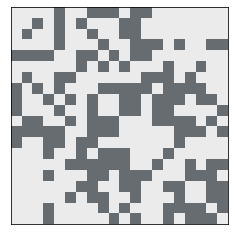

In [3]:
# An ORGM instance can be generated as follows
N = 20
M = 80
edgelist, valid = orgm.ORGM(N=N, M=M, bandwidth=int(round(0.5*N)), epsilon=0.25)

# Convert the edgelist to the graph
N_ = int(1+np.max(edgelist))
g_orgm = igraph.Graph()
g_orgm.add_vertices(N_)
g_orgm.add_edges(edgelist)
Adj = np.array(g_orgm.get_adjacency().data)

res = sns.heatmap(Adj, cmap=cmap, 
                  cbar=False, square=True, xticklabels=False, yticklabels=False)
for _, spine in res.spines.items(): #add frame
    spine.set_visible(True)

The experiment below shows that the p-value is small if an instance of the ORGM is tested.

In [4]:
# Significance test of the unoptimized vertex sequence
s = seq.SequentialLocality(g_orgm)
s.H1()

{'H1': 0.8160714285714286,
 'z1': -2.512942687842473,
 'H1 p-value (ER/ORGM)': 0.005986439194522947,
 'H1 p-value (random)': 0.000576579686183946,
 'bandwidth_opt': None,
 'simple_graph_assumption': True}

## Significance test of the sequential locality for optimized adjacency matrices

When the ordering of the adjacency matrix is optimized (the vertex sequences are optimized) or the matrix has a trivial sequentially local structure, you should try the `in_envelope=True` option. 
In this case, the statistical test of uniformity is conducted within the (estimated) envelope. 

In the experiment below, we use the same graph generated from the ORGM. However, the p-value is typically large when `in_envelope=True` because the ORGM has a uniformly random structure within the envelope.

In [5]:
# Significance test of the optimized vertex sequence
sequence = np.arange(len(g_orgm.vs))
s = seq.SequentialLocality(g=g_orgm, sequence=sequence)
s.H1(in_envelope=True)

{'H1': 0.7316602316602316,
 'z1': -3.5260567115512953,
 'H1 p-value (ER/ORGM)': 0.7965408744321403,
 'H1 p-value (random)': 7.447376913265636e-06,
 'bandwidth_opt': 10,
 'simple_graph_assumption': True}

- The optimized sequence is provided as `sequence` in `SequentialLocality`.
- By setting `in_envelope=True`, you can assess the sequential locality inside of the envelope.
- Unless provided, the optimal bandwidth (`bandwidth_opt`) is automatically determined based on the maximum likelihood estimate of the ORGM.

## Real-world dataset

Hereafter, we show applications using a real-world dataset. 

In [6]:
import graph_tool.all as gt
import spectral

g_real = gt.collection.ns['montreal']
g_real.set_directed(False)
g_real = gt.extract_largest_component(g_real, directed=None, prune=True)

- The input can be an edgelist or a graph object (in igraph or graph-tool)
- The graph has to be undirected & unweighted
- When you use a graph object, you specify the graph format in `format`

### Test for the unoptimized vertex sequence

In [7]:
# Significance test of the unoptimized vertex sequence
s = seq.SequentialLocality(g_real, simple=True, format='graph-tool')
s.H1()

{'H1': 0.9146666666666666,
 'z1': -1.1016485962545546,
 'H1 p-value (ER/ORGM)': 0.13530723628058028,
 'H1 p-value (random)': 0.17180253420327252,
 'bandwidth_opt': None,
 'simple_graph_assumption': True}

### Test for the optimized vertex sequence

In [8]:
# Optimize the vertex sequence using the spectral ordering
inferred_sequence = spectral.spectral_sequence(g_real, normalized=True, format='graph-tool')

# Significance test of the optimized vertex sequence (in-envelope)
s = seq.SequentialLocality(g_real, sequence=inferred_sequence, simple=True, format='graph-tool')
s.H1(in_envelope=True)

{'H1': 0.573170731707317,
 'z1': -4.07417672532254,
 'H1 p-value (ER/ORGM)': 0.9999999986584482,
 'H1 p-value (random)': 7.388270397077806e-05,
 'bandwidth_opt': 8,
 'simple_graph_assumption': True}

### Visualization

Finally, let's visually check out the estimated envelope (white region).

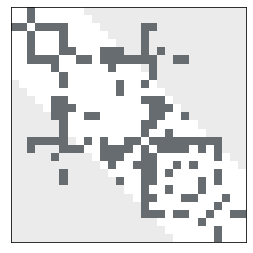

In [9]:
def Adj_vs_ORGM(Adj,r):
    Adj_masked = Adj.copy()
    N = Adj.shape[0]
    for i in range(N-1):
        for j in range(i+r+1,N):
            if Adj[i,j] == 0:
                Adj_masked[i,j] = -1
                Adj_masked[j,i] = -1
    return Adj_masked

fig = plt.subplots(figsize=(4,4))
plt.tight_layout()

N = g_real.num_vertices()
edgelist = g_real.get_edges()
Adj = seq.get_adjacency(N, edgelist)
Adj_opt = seq.Adjacency_optimized(Adj, inferred_sequence)
Adj_ORGM = Adj_vs_ORGM(Adj=Adj_opt, r=s.H1(in_envelope=True)['bandwidth_opt'])

res = sns.heatmap(Adj_ORGM, cmap=cmap,
               cbar=False, square=True, xticklabels=False, yticklabels=False)

for _, spine in res.spines.items(): #add frame
    spine.set_visible(True)